# Triplet implementation with MNIST example

### The paper is described in https://arxiv.org/abs/1412.6622

In [1]:
from tensorflow.examples.tutorials.mnist import input_data # MNIST data
import tensorflow as tf
import numpy as np
import os

In [2]:
# get data
LOGDIR = 'logs/'
mnist = input_data.read_data_sets('/home/vijay/workspace/ml/databases/MNIST_data', one_hot=False)

Extracting /home/vijay/workspace/ml/databases/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/vijay/workspace/ml/databases/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/vijay/workspace/ml/databases/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/vijay/workspace/ml/databases/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# convolve 2d with max_pool

def conv2d_maxpool(x_tensor, n_conv_dim, conv_ksize, conv_strides, pool_ksize, pool_strides, scope='conv'):
    
    in_channels = x_tensor.get_shape().as_list()[3]
    
    with tf.variable_scope(scope):
        weight = tf.get_variable('w', [conv_ksize[0], conv_ksize[1],in_channels, n_conv_dim], tf.float32, 
                            initializer=tf.truncated_normal_initializer(stddev=0.05))
        bias = tf.get_variable('b', [n_conv_dim], tf.float32, 
                           initializer=tf.constant_initializer(0.0))
        
        conv = tf.nn.conv2d(x_tensor, 
                        weight, 
                        strides=[1, conv_strides[0], conv_strides[1], 1],
                        padding = 'SAME')
        
        conv = tf.nn.bias_add(conv, bias)
        conv = tf.nn.relu(conv) 
        conv_maxpool = tf.nn.max_pool(conv,
                                  ksize = [1, pool_ksize[0], pool_ksize[1], 1],
                                  strides = [1, pool_strides[0], pool_strides[1], 1],
                                  padding = 'SAME')
    return conv_maxpool

def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    size = x_tensor.get_shape().as_list()
    x_tensor = tf.reshape(x_tensor, [-1, size[1]*size[2]*size[3]])
    return x_tensor


# fully connected layer
def fc_layer(x_tensor, out_dim, scope='fc'):
    
    in_dim = x_tensor.get_shape().as_list()[1]
    
    with tf.variable_scope(scope):
        w = tf.get_variable('w', [in_dim, out_dim], tf.float32, 
                            initializer=tf.truncated_normal_initializer(stddev=0.05))
        b = tf.get_variable('b', [out_dim], tf.float32, 
                           initializer=tf.constant_initializer(0.0))
        act = tf.matmul(x_tensor, w)+b
        
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)        
        return act
# network

def network(x, dropout):
    
    conv = conv2d_maxpool(x, 96, (3, 3), (1, 1), (2, 2), (2, 2), 'conv1')
    conv = tf.nn.dropout(conv, dropout)
    
    flat = flatten(conv)
    
    fc2 = fc_layer(flat, 1024, 'fc1')
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    fc3 = fc_layer(fc2, 256, 'fc2')
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.l2_normalize(fc3, 1, 1e-10, name='l2-norm')
    return fc3

In [4]:
_, img_size = mnist.train.images.shape
tf.reset_default_graph()

# placeholder for inputs
images_1 = tf.placeholder(tf.float32, [None, img_size], name='img1')
images_2 = tf.placeholder(tf.float32, [None, img_size], name='img2')
labels = tf.placeholder(tf.float32, [None, 1], name='labels')
dropout = tf.placeholder(tf.float32)
margin = 1.0

#Convert to images for conv layer
im_1 = tf.reshape(images_1, [-1, 28, 28, 1])
im_2 = tf.reshape(images_2, [-1, 28, 28, 1])

#model
with tf.variable_scope('Triplet') as scope:
    model1_embed = network(im_1, dropout)
    scope.reuse_variables()
    model2_embed = network(im_2, dropout)
    
d2 = tf.reduce_sum(tf.square(tf.subtract(model1_embed, model2_embed)), 1, keep_dims=True)
distance = tf.sqrt(d2)
C = tf.constant(margin, name='C')
neg = tf.multiply(tf.subtract(1.0, labels) , tf.square(tf.maximum(0., tf.subtract(C, distance))))
pos = tf.multiply(labels, d2)
losses = tf.add(pos, neg)
with tf.name_scope('loss'):
    loss = tf.reduce_mean(losses)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(3e-4).minimize(loss)

summ = tf.summary.merge_all()



In [5]:
#Training
import time
import random
def compute_accuracy(prediction,labels):
    
    return np.mean(labels.ravel() == 1*(predict.ravel() < 0.5))

def create_pairs(x, class_idx):
    pairs = []
    labels = []
    n_class = len(class_idx)
    n = min([len(class_idx[d]) for d in range(n_class)]) - 1
    for d in range(n_class):
        for i in range(n):
            idx1, idx2 = class_idx[d][i], class_idx[d][i+1]
            pairs += [[x[idx1], x[idx2]]]
            rd = random.randrange(1, n_class)
            dn = (d + rd) % n_class
            idx1, idx2 = class_idx[d][i], class_idx[dn][i]
            pairs += [[x[idx1], x[idx2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)
    
def next_batch(s,e,inputs,labels):
    input1 = inputs[s:e,0]
    input2 = inputs[s:e,1]
    y= np.reshape(labels[s:e],(len(range(s,e)),1))
    return input1,input2,y
    
batch_size = 512
n_epoch = 30
saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

#write the summaries
writer = tf.summary.FileWriter(LOGDIR + 'triplet')
writer.add_graph(sess.graph) 

X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

#create training/test positive-negative pairs
n_classes = 10
class_idx = [np.where(y_train == i)[0] for i in range(n_classes)]
train_pairs, train_labels = create_pairs(X_train, class_idx)

class_idx = [np.where(y_test == i)[0] for i in range(n_classes)]
test_pairs, test_labels = create_pairs(X_test, class_idx)

for epoch in range(n_epoch):
    avg_loss = 0.
    avg_acc = 0.
    start_time = time.time()
    train_batch = int(mnist.train.images.shape[0]/batch_size)
    test_batch = int(mnist.test.images.shape[0]/batch_size)
    
    for step in range(train_batch):

        batch_x1, batch_x2, batch_y =next_batch(step*batch_size, (step+1)*batch_size, train_pairs, train_labels)
        _, loss_b = sess.run([optimizer, loss], feed_dict={
                                            images_1: batch_x1,
                                            images_2: batch_x2,
                                            labels: batch_y,
                                            dropout: 0.5})
        avg_loss += loss_b 
        if ((step % 100) == 0) & (step > 0):
            print ('Train step: epoch [%d/%d]: loss: %.3f' % (epoch, n_epoch, avg_loss/(step+1)))
    # Validation
    if ((epoch+1) % 10) == 0:
        acc_avg = 0.
        loss_avg = 0.
        for step in range(test_batch):
            y = np.reshape(test_labels,(test_labels.shape[0],1))
            batch_x1, batch_x2, batch_y =next_batch(step*batch_size, (step+1)*batch_size, test_pairs, test_labels)
            predict, loss_b, summary = sess.run([distance, loss, summ], feed_dict={
                                                    images_1: batch_x1,
                                                    images_2: batch_x2,
                                                    labels: batch_y,
                                                    dropout: 1.0})
            writer.add_summary(summary, epoch*test_batch+step)
            acc = compute_accuracy(predict, batch_y)
            acc_avg += acc
            loss_avg += loss_b
        acc_avg /= test_batch
        loss_avg /= test_batch
        duration = time.time() - start_time
        print ('Validation: epoch [%d/%d]: loss: %.3f accuracy: %.3f, duration: %.3f' % (epoch,n_epoch, loss_avg, acc_avg, duration))
print('Training completed ...')
saver.save(sess, os.path.join(LOGDIR, 'triplet.ckpt'))
embed = sess.run(model1_embed, feed_dict= {images_1: mnist.test.images, dropout: 1.0})
sess.close()

Train step: epoch [0/30]: loss: 0.217
Validation: epoch [0/30]: loss: 0.156 accuracy: 0.768, duration: 27.870
Train step: epoch [1/30]: loss: 0.142
Train step: epoch [2/30]: loss: 0.098
Train step: epoch [3/30]: loss: 0.070
Train step: epoch [4/30]: loss: 0.055
Train step: epoch [5/30]: loss: 0.045
Train step: epoch [6/30]: loss: 0.038
Train step: epoch [7/30]: loss: 0.033
Train step: epoch [8/30]: loss: 0.028
Train step: epoch [9/30]: loss: 0.024
Train step: epoch [10/30]: loss: 0.020
Validation: epoch [10/30]: loss: 0.015 accuracy: 0.984, duration: 26.888
Train step: epoch [11/30]: loss: 0.017
Train step: epoch [12/30]: loss: 0.015
Train step: epoch [13/30]: loss: 0.013
Train step: epoch [14/30]: loss: 0.011
Train step: epoch [15/30]: loss: 0.010
Train step: epoch [16/30]: loss: 0.009
Train step: epoch [17/30]: loss: 0.008
Train step: epoch [18/30]: loss: 0.007
Train step: epoch [19/30]: loss: 0.006
Train step: epoch [20/30]: loss: 0.005
Validation: epoch [20/30]: loss: 0.010 accurac

## Plot the embeddings using t-sne
http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter

In [18]:
from sklearn.manifold import TSNE
display_only = 2000
tsne = TSNE(n_components=2)
reduced_dim = tsne.fit_transform(embed[:display_only])

In [19]:
import matplotlib.pyplot as plt
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, n_classes))

    # Get the color for each sample.
    colors = cmap[cls]

    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.scatter(x, y, color=colors)
    plt.show()

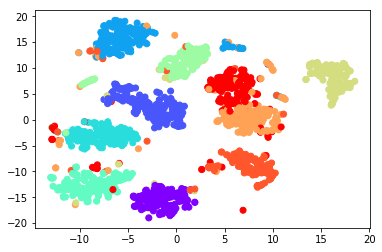

In [20]:
plot_scatter(reduced_dim, mnist.test.labels[:display_only])

In [16]:
from tensorflow.contrib.tensorboard.plugins import projector

def generate_embeddings(embed):
    sess= tf.InteractiveSession()
    writer = tf.summary.FileWriter(LOGDIR + '/projector', sess.graph)
    embedding = tf.Variable(embed[:1024], trainable=False, name='embedding')
    
    saver = tf.train.Saver()
    
    
    sess.run(tf.global_variables_initializer())
       
    config = projector.ProjectorConfig()
    embedding_config = config.embeddings.add()
    embedding_config.tensor_name = embedding.name
    
    with open(LOGDIR +'projector/metadata.tsv', 'w') as f:
        for label in mnist.test.labels[:1024]:
            f.write('{}\n'.format(label))
    embedding_config.metadata_path = LOGDIR +'projector/metadata.tsv'
    embedding_config.sprite.image_path = 'mnist_10k_sprite.png'
    
    embedding_config.sprite.single_image_dim.extend([28, 28])
    projector.visualize_embeddings(writer, config)
    
    saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), 1)
    show_graph(tf.get_default_graph().as_graph_def())
    sess.close()
    